In [20]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt

In [21]:
def load_data():
    df = pd.read_csv('../Dataset/data.csv')
    return df

In [22]:
data = load_data()
data.head()

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,517544.0,"DK, FI, NO, SE"
1,Unforgiven,movie,"Drama, Western",1992.0,tt0105695,8.2,444345.0,"AD, AG, AR, BB, BE, BO, BR, BS, BZ, CL, CO, CR..."
2,Eternal Sunshine of the Spotless Mind,movie,"Drama, Romance, Sci-Fi",2004.0,tt0338013,8.3,1105967.0,"AG, AR, BB, BO, BS, BZ, CL, CO, CR, DO, EC, GT..."
3,A History of Violence,movie,"Action, Crime, Drama",2005.0,tt0399146,7.4,259262.0,"AG, AR, BB, BO, BR, BS, BZ, CL, CO, CR, DO, EC..."
4,2001: A Space Odyssey,movie,"Adventure, Sci-Fi",1968.0,tt0062622,8.3,736401.0,"AD, AG, AR, BB, BE, BO, BR, BS, BZ, CL, CO, CR..."


In [23]:
# get length of countries for better anlaysis
data['num_countries'] = data['availableCountries'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

#time since release
data['Years Since Release'] = 2024 - data["releaseYear"]

In [24]:
data.head()

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,num_countries,Years Since Release
0,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,517544.0,"DK, FI, NO, SE",4,27.0
1,Unforgiven,movie,"Drama, Western",1992.0,tt0105695,8.2,444345.0,"AD, AG, AR, BB, BE, BO, BR, BS, BZ, CL, CO, CR...",34,32.0
2,Eternal Sunshine of the Spotless Mind,movie,"Drama, Romance, Sci-Fi",2004.0,tt0338013,8.3,1105967.0,"AG, AR, BB, BO, BS, BZ, CL, CO, CR, DO, EC, GT...",26,20.0
3,A History of Violence,movie,"Action, Crime, Drama",2005.0,tt0399146,7.4,259262.0,"AG, AR, BB, BO, BR, BS, BZ, CL, CO, CR, DO, EC...",27,19.0
4,2001: A Space Odyssey,movie,"Adventure, Sci-Fi",1968.0,tt0062622,8.3,736401.0,"AD, AG, AR, BB, BE, BO, BR, BS, BZ, CL, CO, CR...",38,56.0


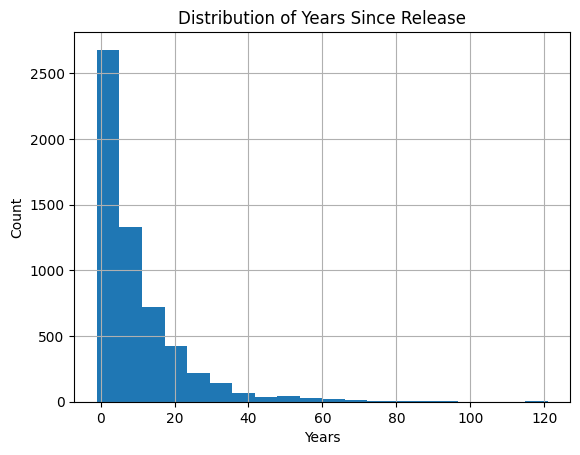

In [35]:
data['Years Since Release'].hist(bins=20)
plt.title('Distribution of Years Since Release')
plt.xlabel('Years')
plt.ylabel('Count')
plt.show()

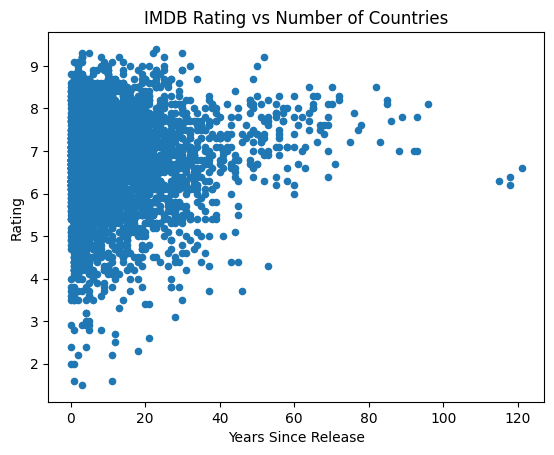

In [39]:
data.plot.scatter(x='Years Since Release', y='imdbAverageRating')
plt.title('IMDB Rating vs Number of Countries')
plt.xlabel('Years Since Release')
plt.ylabel('Rating')
plt.show()

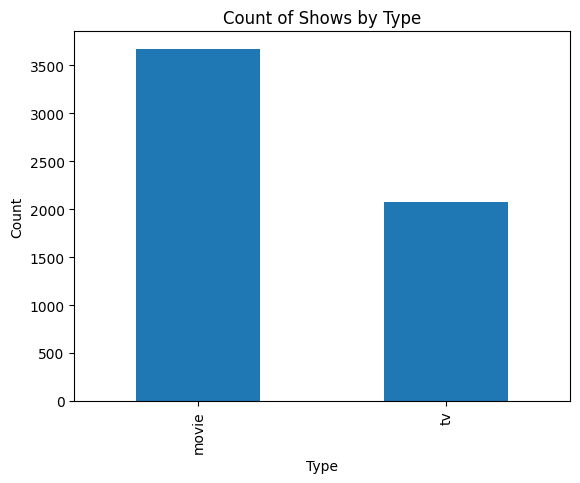

In [40]:
data['type'].value_counts().plot(kind='bar')
plt.title('Count of Shows by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()
